# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [2]:
%matplotlib notebook

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            #.config('spark.master', "local[6]")
            .config('spark.master', "local[24]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Find the best "dippers"

In [5]:
# Load a small catalog where we have used loose selection cuts
# to find dippers.
wtf = catalog.load('wtf_full_oct19_4')

In [6]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    .drop('dip')
    .select(
        '*',
        dipper.build_analyze_dip_udf(max_gap=2.5, min_dip_time=2.)(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significance") > 20)
        & (sparkfunc.col("dip.reference_stability") < 1.3)
    )
)

In [7]:
%%time

# Get the best dippers
best_dippers = rescored_wtf.sort(rescored_wtf['dip.score'].desc()).head(1000)

CPU times: user 201 ms, sys: 77.4 ms, total: 278 ms
Wall time: 24.5 s


In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


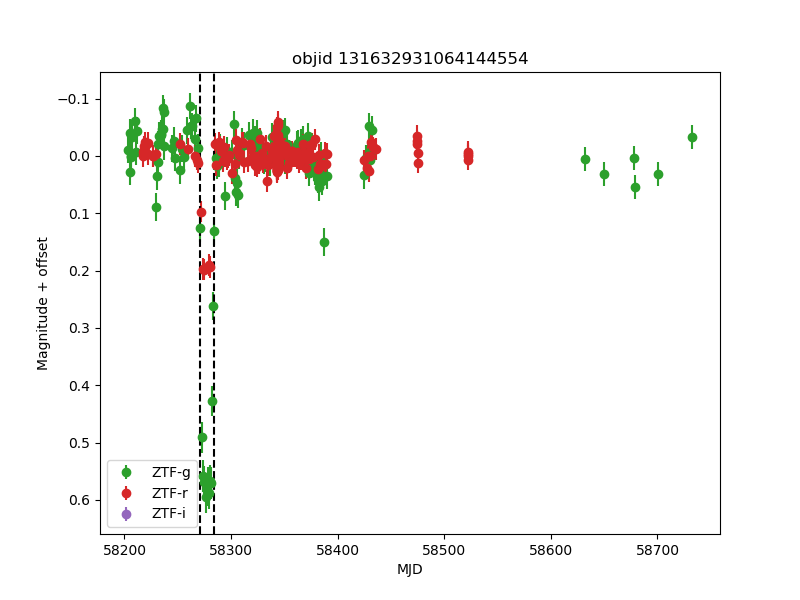

In [9]:
# Plot a light curve
dipper.plot_light_curve(best_dippers[0], verbose=False)

In [10]:
%matplotlib inline

In [12]:
# Show an interactive display of the light curves
dipper.plot_interactive(best_dippers)

interactive(children=(IntSlider(value=0, description='idx', max=339), Checkbox(value=True, description='parsed…

In [42]:
f = best_dippers[15]
mag = np.array(f['mag_r'])
magerr = np.array(f['magerr_r'])
mjd = np.array(f['mjd_r'])

mask = (mjd > f['dip']['end_mjd'] + 5) | (mjd < f['dip']['start_mjd'] - 5)

print(mag[mask], magerr[mask])

[19.31238937 19.54449463 19.33548546 20.03564453 19.42291451 19.41320801
 19.41982269 19.28969383 19.72787285 19.49627876 19.43577957 19.54478073] [0.08285842 0.09530707 0.08403737 0.12409504 0.08862466 0.08810589
 0.08845916 0.08171364 0.10591669 0.09261753 0.08931572 0.09532318]


# Rerun over the full ZTF dataset

Warning! This takes a long time to run. It is recommended to increase the number of cores that spark is running on before you execute this (e.g, in the spark setup change `.config('spark.master', "local[6]")` which uses 6 cores to something larger. When running on 32 cores, this runs on epyc in ~10 hours. 

In [5]:
# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

In [ ]:
%%time

# Run the dip detection query on the full ZTF dataset on spark
result = (
    ztf
    .exclude_duplicates()
    #.region(ra1=295, ra2=296, dec1=20, dec2=21)
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
    .select(
        '*',
        dipper.build_analyze_dip_udf(max_gap=2.)(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significance") > 10.)
        & (sparkfunc.col("dip.reference_stability") < 2.)
    )
    .write.parquet('./query_wtf_3.parquet')
)

In [6]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('./query_wtf_3.parquet')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_5', repartition=True)

AnalysisException: 'Unable to infer schema for Parquet. It must be specified manually.;'